# Replication results adversarial learning
Edwards and Stokey train 100 models on the train set, compute the performance as ($\sum_{i} C(y_{i}|x_{i}, s_{i}) = y_{i}) - t * |\sum_{i:s_{0}} C(y_{i}|x_{i}, s_{i}) / n_{s_{0}} - \sum_{i:s_{1}} C(y_{i}|x_{i}, s_{i}) / n_{s_{1}}|$ , $t \in [0,3]$ for varying values of $t$ on the validation set and then compute the performance on the test set (without retraining). The exact same approach was taken by the author. 


## Data preparation

See http://www.cs.toronto.edu/~zemel/documents/fair-icml-supp-final.pdf for the details (Edwards and Stokey based their data preparation on this paper). Quantitative data is quantilized as per the link. 


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True)
% cd gdrive/My Drive/Masterarbeit

import preprocess 
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import matplotlib.pyplot as plt
import sklearn 
import torch
import torch.nn as nn
import torch.utils.data
import pickle
import warnings
from sklearn.linear_model import LogisticRegression
import os

warnings.simplefilter(action='ignore', category=FutureWarning)


adult = pd.read_csv('Dataset.data', delimiter = ' ', header = None)
adult = preprocess.pre_process_adult(adult)
class dataset_for_preprocessed(torch.utils.data.Dataset):
  def __init__(self, data_set, sensitive_variable):
    self.tensor_data = torch.from_numpy(data_set.values.astype(np.float32))
    self.sensitive_variable = sensitive_variable
  def __len__(self):
    return len(self.tensor_data)

  def __getitem__(self, idx):
    feature_cols       = [x for x in range(self.tensor_data.size()[1]) if x != self.tensor_data.size()[1]-1]
    features           = self.tensor_data[idx, feature_cols]
    sensitive_variable = self.tensor_data[idx, self.sensitive_variable]
    labels             = self.tensor_data[idx, -1]
    return features, sensitive_variable, labels





Mounted at /content/gdrive/
/content/gdrive/My Drive/Masterarbeit


## Model Definition

Model is defined so as to allow a two / three hidden layer classifier and a logistic regression / one hidden layer adversary (domain classifier).

In [0]:
class label_classifier(nn.Module):
  
     def __init__(self, D_in, hidden, clas_simple):
         
       super(label_classifier, self).__init__()
       self.clas_simple = clas_simple
          
       self.linear_1  = nn.Linear(D_in, hidden) 
       self.linear_2  = nn.Linear(hidden, hidden)
       self.linear_3  = nn.Linear(hidden, hidden)
       self.linear_4  = nn.Linear(hidden, 1)


 
     def forward(self,x):
       if self.clas_simple == 0:
         hidden   =  nn.ReLU()(self.linear_3(nn.ReLU()(self.linear_2(nn.ReLU()(self.linear_1(x))))))
       elif self.clas_simple == 1:
         hidden   =  nn.ReLU()(self.linear_2(nn.ReLU()(self.linear_1(x))))
       else:
         hidden   =  nn.ReLU()(self.linear_1(x))
       out      =  nn.Sigmoid()(self.linear_4(hidden))
       return(out, hidden)

      
class domain_classifier(nn.Module):
  
     def __init__(self, hidden, adv_simple):
      
       super(domain_classifier, self).__init__()
       self.adv_simple = adv_simple
       self.linear_1 = nn.Linear(hidden, hidden)
       self.linear_2 = nn.Linear(hidden, hidden)
       self.linear_3 = nn.Linear(hidden, 1)
        
     def forward(self, x):
       if self.adv_simple ==0:  
         out      = nn.Sigmoid()(self.linear_3(nn.ReLU()(self.linear_1(x))))
       elif self.adv_simple == 1:
         out      = nn.Sigmoid()(self.linear_3(nn.ReLU()(self.linear_2(nn.ReLU()(self.linear_1(x))))))
       else:
         out      = nn.Sigmoid()(self.linear_3(x))
       return(out)

## Model Training and selection

Edwards and Stokey perform random search over hyperparameters. Here random search  was performed over a narrower set of hyperparameters  with a uniform distribution. Models are trained in a loop with varying hyperparameters on one training set. Adversary and classifier are trained alternatingly as described in the paper.

In [0]:
results_dict = {}
data_set = adult
data_set_size = adult.shape[1]
sensitive_variable = adult.columns.get_loc('Gender_Male')
data_set = data_set.sample(frac=1, random_state = 0)

data_set_train = dataset_for_preprocessed(adult.iloc[:23000,:], sensitive_variable)  
data_set_valid = dataset_for_preprocessed(adult.iloc[23000:33000,:], sensitive_variable)  
data_set_test = dataset_for_preprocessed(adult.iloc[33000:,:], sensitive_variable)  

batch_size = 100

dataloader_train = torch.utils.data.DataLoader(data_set_train, batch_size = batch_size, shuffle = True)
dataloader_valid = torch.utils.data.DataLoader(data_set_valid, batch_size = 10000, shuffle = False)
dataloader_test = torch.utils.data.DataLoader(data_set_test, batch_size = len(adult)-33000, shuffle = False)

criterion  = nn.BCELoss()
for i in range(100):
  hidden      = np.asscalar(np.random.choice(np.arange(16,96),1))
  clas_simple = 0#np.asscalar(np.random.choice(np.arange(0,3),1))
  adv_simple  = 0 #np.asscalar(np.random.choice(np.arange(0,3),1))
  weight      = np.asscalar(np.random.uniform(0,40, 1))
  lr          = np.random.uniform(0.001, 0.0001)
  model_label = label_classifier(data_set_size-1, hidden, clas_simple).cuda()
  model_domain = domain_classifier(hidden, adv_simple).cuda()
  optimizer_label = torch.optim.Adam(model_label.parameters(), lr = 0.0001)
  optimizer_domain = torch.optim.Adam(model_domain.parameters(), lr = lr)
  batch_counter = 0
  for epoch in range(50):
    for batch in dataloader_train:
      X, s, y = batch
      X, s, y = X.cuda(), s.cuda(), y.cuda()
      out_label, out_features  = model_label(X)
      out_domain       = model_domain(out_features)
      loss_domain      = criterion(out_domain, s.unsqueeze(1)) 
      loss_label       = criterion(out_label, y.unsqueeze(1))
      loss_domain.backward(retain_graph = True)
      for parameter in model_label.parameters():
        if parameter.grad is not None:
          parameter.grad *= - weight
      loss_label.backward() 
      if batch_counter % 2 == 0:
        optimizer_label.step()
      else:
        optimizer_domain.step()
      optimizer_label.zero_grad()
      optimizer_domain.zero_grad()
      batch_counter += 1
  batch = next(iter(dataloader_valid))
  X, s, y = batch
  X, s, y = X.cuda(), s.cuda(), y.cuda()
  out_label, out_features  = model_label(X)
  accuracy_valid = ((out_label.squeeze()>0.5).int() == y.int()).sum().float()/len(X)
  fairness_valid = -(out_label>0.5)[s==0].sum().float()/len(X) + (out_label>0.5)[s==1].sum().float()/len(X)
  
  batch = next(iter(dataloader_test))
  X, s, y = batch
  X, s, y = X.cuda(), s.cuda(), y.cuda()
  out_label, out_features  = model_label(X)
  accuracy_test = ((out_label.squeeze()>0.5).int() == y.int()).sum().float()/len(X)
  fairness_test = -(out_label>0.5)[s==0].sum().float()/len(X) + (out_label>0.5)[s==1].sum().float()/len(X)
  
  results_dict[i] = {'accuracy_valid': accuracy_valid, 'fairness_valid': fairness_valid, 'accuracy_test': accuracy_test, 'fairness_test': fairness_test}
  try:
    os.makedirs(f'reproduce_adversarial/')
  except FileExistsError:
    pass
  torch.save(results_dict[i], f'reproduce_adversarial/{i}.tar')
  print(results_dict[i])





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


{'accuracy_valid': tensor(0.7539, device='cuda:0'), 'fairness_valid': tensor(0., device='cuda:0'), 'accuracy_test': tensor(0.7469, device='cuda:0'), 'fairness_test': tensor(0., device='cuda:0')}
{'accuracy_valid': tensor(0.7539, device='cuda:0'), 'fairness_valid': tensor(0., device='cuda:0'), 'accuracy_test': tensor(0.7469, device='cuda:0'), 'fairness_test': tensor(0., device='cuda:0')}
{'accuracy_valid': tensor(0.8074, device='cuda:0'), 'fairness_valid': tensor(0.0793, device='cuda:0'), 'accuracy_test': tensor(0.8044, device='cuda:0'), 'fairness_test': tensor(0.0800, device='cuda:0')}
{'accuracy_valid': tensor(0.7539, device='cuda:0'), 'fairness_valid': tensor(0., device='cuda:0'), 'accuracy_test': tensor(0.7469, device='cuda:0'), 'fairness_test': tensor(0., device='cuda:0')}


In [0]:
data_adv = pd.DataFrame.from_dict(results_dict, orient = 'index')
best_model_list = []
results_list_adv    = []
for tau in np.linspace(0, 3, 100):
  value = np.array(data_adv['accuracy_valid']) - tau * np.array(data_adv['fairness_valid']))
  idx = np.nanargmax(value)
  results_list_adv.append(data_adv.iloc[idx, 2]- tau * data_adv.iloc[idx,3])
  best_model_list.append(idx)

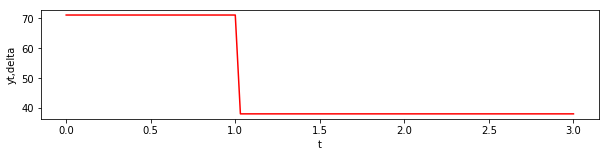

In [0]:
plt.figure(figsize = (10,2))
plotdata = pd.DataFrame({'yt,delta':best_model_list,'t': np.linspace(0,3,100)})
sns.lineplot(y = 'yt,delta', x = 't', data = plotdata, color = 'red')
plt.xlabel('t')
plt.ylabel('yt,delta')
plt.title('Results pytorch implementation')
plt.savefig('yt_delta.png')


In [0]:
plt.figure(figsize = (10,2))
plotdata = pd.DataFrame({'accuracy':[np.asscalar(i.numpy()) for i in acc_list_correct],'t': np.linspace(0,3,100)})
sns.lineplot(y = 'accuracy', x = 't', data = plotdata, color = 'red')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-725fdf478e06>", line 2, in <module>
    plotdata = pd.DataFrame({'accuracy':[np.asscalar(i.numpy()) for i in acc_list_correct],'t': np.linspace(0,3,100)})
NameError: name 'acc_list_correct' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_o

NameError: ignored

<Figure size 720x144 with 0 Axes>

In [0]:
plt.figure(figsize = (10,2))
plotdata = pd.DataFrame({'fairness':[np.asscalar(i.numpy()) for i in fair_list_correct],'t': np.linspace(0,3,100)})
sns.lineplot(y = 'fairness', x = 't', data = plotdata, color = 'red')
plt.savefig('edward_fairness.png')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-5da37374210d>", line 2, in <module>
    plotdata = pd.DataFrame({'fairness':[np.asscalar(i.numpy()) for i in fair_list_correct],'t': np.linspace(0,3,100)})
NameError: name 'fair_list_correct' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number

NameError: ignored

<Figure size 720x144 with 0 Axes>